# Generate full emissions portfolio from projected Kyoto gas baskets
Updated to include announcements as of COP26, 5/11/21. Including an analysis of full impact of Net Zero commitments on emissions.
# Part 2: harmonise data

In [1]:
import sys
stdout = sys.stdout

In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import pyam
import re
import seaborn as sns
from scipy.interpolate import interp1d, PchipInterpolator

<IPython.core.display.Javascript object>

In [3]:
import country_converter

In [4]:
from silicone.time_projectors import ExtendLatestTimeQuantile
import silicone.multiple_infillers as mi
import silicone.database_crunchers as dc
from silicone.utils import convert_units_to_MtCO2_equiv, _construct_consistent_values

In [5]:
version_no = "r10_1"

# Import the data

In [6]:
co2 = "Emissions|CO2"
co2ind = "Emissions|CO2|Energy and Industrial Processes"
co2afolu = "Emissions|CO2|AFOLU"
variable = "Emissions|Kyoto Gases (AR6-GWP100)"
kyexaf = variable + "|Excluding CO2 AFOLU"
unit = "Mt CO2-equiv/yr"
co2unit = "Mt CO2/yr"
years = [2015, 2019] + list(range(2010, 2101, 10))

In [7]:
out_folder = f"../output/processed_files/{version_no}/"
sr15 = pyam.IamDataFrame(out_folder + "ar6_cleaned.csv")

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ..\output\processed_files\r10_1\ar6_cleaned.csv


In [8]:
# Import data on expected projection of emissions
readin_data = pd.read_excel(
    "../input/Data2030_forextensions_EGR2023_master.xlsx", sheet_name="Extracted data EGR2023")
readin_data.columns = ["scenario", "model"] + list(readin_data.columns[2:5]) + ["unit"]

In [9]:
models = ["MESSAGEix-GLOBIOM_1.1", "REMIND-MAgPIE 2.1-4.2"]

In [10]:
harmonise_regions_to_whole = False

In [11]:
readin_data

,scenario,model,2015,2021,2030,unit
0,Min,Current policies,54903.825515,56538.455018,51754.515639,MtCO2-eq/yr (aggregated with AR6 GWP-100 metri...
1,Median,Current policies,54903.825515,56538.455018,56499.478534,MtCO2-eq/yr (aggregated with AR6 GWP-100 metri...
2,Max,Current policies,54903.825515,56538.455018,59927.353077,MtCO2-eq/yr (aggregated with AR6 GWP-100 metri...
3,Min,NDC case - unconditional,54903.825515,56538.455018,53813.678367,MtCO2-eq/yr (aggregated with AR6 GWP-100 metri...
4,Median,NDC case - unconditional,54903.825515,56538.455018,55148.146536,MtCO2-eq/yr (aggregated with AR6 GWP-100 metri...
5,Max,NDC case - unconditional,54903.825515,56538.455018,57095.963315,MtCO2-eq/yr (aggregated with AR6 GWP-100 metri...
6,Min,NDC case - conditional,54903.825515,56538.455018,50032.435822,MtCO2-eq/yr (aggregated with AR6 GWP-100 metri...
7,Median,NDC case - conditional,54903.825515,56538.455018,51683.988603,MtCO2-eq/yr (aggregated with AR6 GWP-100 metri...
8,Max,NDC case - conditional,54903.825515,56538.455018,55293.627546,MtCO2-eq/yr (aggregated with AR6 GWP-100 metri...


In [12]:
variable = "Emissions|Kyoto Gases (AR6-GWP100)"
unit = "Mt CO2-equiv/yr"
raw_data = readin_data
raw_data["region"] = "World"
raw_data["unit"] = unit
raw_data["variable"] = variable
raw_data = pyam.IamDataFrame(raw_data)
raw_data = raw_data.interpolate([2015, 2019, 2020])
raw_data.data.head()

,model,scenario,region,variable,unit,year,value
0,Current policies,Max,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2015,54903.825515
1,Current policies,Max,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2019,55993.578517
2,Current policies,Max,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2020,56266.016767
3,Current policies,Max,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2021,56538.455018
4,Current policies,Max,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2030,59927.353077


In [13]:
# Import historical database
histall = pd.read_excel("../input/essd_ghg_data.xlsx", sheet_name="data")
histall["variable"] = ["Emissions|" + x for x in histall["gas"]]
histall

,ISO,country,region_ar6_6,region_ar6_10,region_ar6_22,region_ar6_dev,year,sector_title,subsector_title,gas,gwp100_ar5,value,variable
0,ABW,Aruba,Latin America and Caribbean,Latin America and Caribbean,Caribbean,developing,1970,Buildings,Residential,CO2,1,5.452099e+02,Emissions|CO2
1,ABW,Aruba,Latin America and Caribbean,Latin America and Caribbean,Caribbean,developing,1970,Buildings,Residential,CH4,28,1.609412e-01,Emissions|CH4
2,ABW,Aruba,Latin America and Caribbean,Latin America and Caribbean,Caribbean,developing,1970,Buildings,Residential,N2O,265,4.802031e-03,Emissions|N2O
3,ABW,Aruba,Latin America and Caribbean,Latin America and Caribbean,Caribbean,developing,1970,Energy systems,Electricity & heat,CO2,1,3.091397e+04,Emissions|CO2
4,ABW,Aruba,Latin America and Caribbean,Latin America and Caribbean,Caribbean,developing,1970,Energy systems,Electricity & heat,CH4,28,4.155721e-01,Emissions|CH4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
568336,ZWE,Zimbabwe,Africa,Africa,Eastern Africa,developing,2020,Industry,Metals,CO2,1,7.720092e+05,Emissions|CO2
568337,ZWE,Zimbabwe,Africa,Africa,Eastern Africa,developing,2020,Industry,Other (industry),CO2,1,9.523549e+05,Emissions|CO2
568338,ZWE,Zimbabwe,Africa,Africa,Eastern Africa,developing,2020,Transport,Other (transport),CO2,1,3.099450e+05,Emissions|CO2
568339,ZWE,Zimbabwe,Africa,Africa,Eastern Africa,developing,2020,Transport,Rail,CO2,1,1.491236e+05,Emissions|CO2


In [14]:
histall["region_ar6_10"].unique()

array(['Latin America and Caribbean', 'Southern Asia', 'Africa',
       'Intl. Aviation', 'Europe', 'Middle East', 'Eurasia',
       'South-East Asia and developing Pacific', 'Asia-Pacific Developed',
       'North America', 'Eastern Asia', 'Intl. Shipping'], dtype=object)

In [15]:
sr15.region

['R10AFRICA',
 'R10CHINA+',
 'R10EUROPE',
 'R10INDIA+',
 'R10LATIN_AM',
 'R10MIDDLE_EAST',
 'R10NORTH_AM',
 'R10PAC_OECD',
 'R10REF_ECON',
 'R10REST_ASIA',
 'R10ROWO',
 'World']

In [16]:
region_dict = {
    'Latin America and Caribbean': "R10LATIN_AM",
    'Southern Asia': "R10INDIA+", 
    'Africa': "R10AFRICA",
    'Intl. Aviation':"R10ROWO",
    'Europe': "R10EUROPE", 
    'Middle East': "R10MIDDLE_EAST", 
    'Eurasia': "R10REF_ECON",
    'South-East Asia and developing Pacific': "R10REST_ASIA", 
    'Asia-Pacific Developed': "R10PAC_OECD",
    'North America': "R10NORTH_AM", 
    'Eastern Asia': "R10CHINA+", 
    'Intl. Shipping': "R10ROWO"
}

In [17]:
histall["region"] = [region_dict[x] for x in histall["region_ar6_10"]]

In [18]:
# Remove AFOLU data from CO2, which is mixed in this database
histall = histall.loc[~((histall.gas=="CO2") & (histall["subsector_title"]=='Managed soils and pasture (CO2, N2O)'))]

In [19]:
histall

,ISO,country,region_ar6_6,region_ar6_10,region_ar6_22,region_ar6_dev,year,sector_title,subsector_title,gas,gwp100_ar5,value,variable,region
0,ABW,Aruba,Latin America and Caribbean,Latin America and Caribbean,Caribbean,developing,1970,Buildings,Residential,CO2,1,5.452099e+02,Emissions|CO2,R10LATIN_AM
1,ABW,Aruba,Latin America and Caribbean,Latin America and Caribbean,Caribbean,developing,1970,Buildings,Residential,CH4,28,1.609412e-01,Emissions|CH4,R10LATIN_AM
2,ABW,Aruba,Latin America and Caribbean,Latin America and Caribbean,Caribbean,developing,1970,Buildings,Residential,N2O,265,4.802031e-03,Emissions|N2O,R10LATIN_AM
3,ABW,Aruba,Latin America and Caribbean,Latin America and Caribbean,Caribbean,developing,1970,Energy systems,Electricity & heat,CO2,1,3.091397e+04,Emissions|CO2,R10LATIN_AM
4,ABW,Aruba,Latin America and Caribbean,Latin America and Caribbean,Caribbean,developing,1970,Energy systems,Electricity & heat,CH4,28,4.155721e-01,Emissions|CH4,R10LATIN_AM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568336,ZWE,Zimbabwe,Africa,Africa,Eastern Africa,developing,2020,Industry,Metals,CO2,1,7.720092e+05,Emissions|CO2,R10AFRICA
568337,ZWE,Zimbabwe,Africa,Africa,Eastern Africa,developing,2020,Industry,Other (industry),CO2,1,9.523549e+05,Emissions|CO2,R10AFRICA
568338,ZWE,Zimbabwe,Africa,Africa,Eastern Africa,developing,2020,Transport,Other (transport),CO2,1,3.099450e+05,Emissions|CO2,R10AFRICA
568339,ZWE,Zimbabwe,Africa,Africa,Eastern Africa,developing,2020,Transport,Rail,CO2,1,1.491236e+05,Emissions|CO2,R10AFRICA


In [20]:
histall.loc[(histall.year==2019)&(histall.gas=="CO2"), "subsector_title"].unique()

array(['Non-residential', 'Residential', 'Electricity & heat',
       'Other (energy systems)', 'Chemicals', 'Other (industry)',
       'Domestic Aviation', 'Inland Shipping', 'Other (transport)',
       'Road', 'Coal mining fugitive emissions', 'Cement', 'Metals',
       'Oil and gas fugitive emissions', 'Petroleum refining',
       'International Aviation', 'Waste', 'Rail ',
       'International Shipping'], dtype=object)

In [21]:
histallgroup = histall.drop(columns=["gwp100_ar5"]).groupby(["year", "variable", "region"]).sum()

In [22]:
histallworld = histallgroup.groupby(["year", "variable"]).sum()
histallworld["region"] = "World"
histallworld

value region
year variable                             
1970 Emissions|C2F6    1.155521e+03  World
     Emissions|C3F8    0.000000e+00  World
     Emissions|C4F10   0.000000e+00  World
     Emissions|C5F12   0.000000e+00  World
     Emissions|C6F14   0.000000e+00  World
...                             ...    ...
2019 Emissions|N2O     9.739023e+06  World
     Emissions|NF3     1.421996e+02  World
     Emissions|SF6     8.833537e+03  World
     Emissions|c-C4F8  7.714975e+01  World
2020 Emissions|CO2     3.582252e+10  World

[1401 rows x 2 columns]

In [23]:
r10regions = pd.read_csv("../input/iso3c_region_mapping.csv")
region_map = {
    "AFR": 'R10AFRICA',
    "EAS": 'R10CHINA+',
    "EUR": 'R10EUROPE',
    "SAS": 'R10INDIA+',
    "LAM": 'R10LATIN_AM',
    "MEA": 'R10MIDDLE_EAST',
    "NAM": 'R10NORTH_AM',
    "PAO": 'R10PAC_OECD',
    "FSU": 'R10REF_ECON',
    "PAS": 'R10REST_ASIA',
}

In [44]:
r10regions = r10regions.set_index("iso3c")

In [45]:
r10regions.head()

,country.name,iamc_r5,iamc_r10,iamc_r11,iamc_r12,region_ar6_6_ipcc_fgd,region_ar6_10_ipcc_fgd,region_ar6_22_ipcc_fgd,Annex_I_unfccc,EU,OECD,Income _status_WB
iso3c,,,,,,,,,,,,
CHN,China,ASIA,EAS,CPA,CHN,Asia and developing Pacific,Eastern Asia,Eastern Asia,Non-Annex I,NaN,NaN,Upper middle
HKG,"Hong Kong SAR, China",ASIA,EAS,CPA,CHN,Asia and developing Pacific,Eastern Asia,Eastern Asia,Territory,NaN,NaN,High
MAC,"Macao SAR, China",ASIA,EAS,CPA,CHN,Asia and developing Pacific,Eastern Asia,Eastern Asia,Territory,NaN,NaN,High
MNG,Mongolia,ASIA,EAS,CPA,RCPA,Asia and developing Pacific,Eastern Asia,Eastern Asia,Non-Annex I,NaN,NaN,Lower-middle
PRK,"Korea, Dem. People's Rep.",ASIA,EAS,CPA,RCPA,Asia and developing Pacific,Eastern Asia,Eastern Asia,Non-Annex I,NaN,NaN,Low


In [53]:
histall["region2"] = [region_map[r10regions.loc[iso3, "iamc_r10"]] if (iso3 not in ["EU", "AIR", "ANT", "SCG", "SEA"]) else "temp" for iso3 in histall["ISO"]]

C:\Users\rlamboll\Anaconda3\envs\silicone-1\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [59]:
histall.loc[histall["region2"] !=histall["region"], ["country", "region2", "region"]].drop_duplicates(keep='first')

,country,region2,region
7780,Int. Aviation,temp,R10ROWO
10752,Netherlands Antilles,temp,R10LATIN_AM
65357,Bermuda,R10LATIN_AM,R10NORTH_AM
149500,Algeria,R10MIDDLE_EAST,R10AFRICA
155445,"Egypt, Arab Rep.",R10MIDDLE_EAST,R10AFRICA
160246,Western Sahara,R10MIDDLE_EAST,R10AFRICA
222852,Guam,R10NORTH_AM,R10REST_ASIA
303526,Libya,R10MIDDLE_EAST,R10AFRICA
325691,Morocco,R10MIDDLE_EAST,R10AFRICA
338992,"Macedonia, FYR",R10EUROPE,R10REF_ECON


In [31]:
r10regions

,country.name,iso3c,iamc_r5,iamc_r10,iamc_r11,iamc_r12,region_ar6_6_ipcc_fgd,region_ar6_10_ipcc_fgd,region_ar6_22_ipcc_fgd,Annex_I_unfccc,EU,OECD,Income _status_WB
0,China,CHN,ASIA,EAS,CPA,CHN,Asia and developing Pacific,Eastern Asia,Eastern Asia,Non-Annex I,NaN,NaN,Upper middle
1,"Hong Kong SAR, China",HKG,ASIA,EAS,CPA,CHN,Asia and developing Pacific,Eastern Asia,Eastern Asia,Territory,NaN,NaN,High
2,"Macao SAR, China",MAC,ASIA,EAS,CPA,CHN,Asia and developing Pacific,Eastern Asia,Eastern Asia,Territory,NaN,NaN,High
3,Mongolia,MNG,ASIA,EAS,CPA,RCPA,Asia and developing Pacific,Eastern Asia,Eastern Asia,Non-Annex I,NaN,NaN,Lower-middle
4,"Korea, Dem. People's Rep.",PRK,ASIA,EAS,CPA,RCPA,Asia and developing Pacific,Eastern Asia,Eastern Asia,Non-Annex I,NaN,NaN,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,Russian Federation,RUS,REF,FSU,FSU,FSU,Eastern Europe and West-Central Asia,Eastern Europe and West-Central Asia,Eastern Europe and West-Central Asia,Annex I,NaN,NaN,Upper middle
244,Tajikistan,TJK,REF,FSU,FSU,FSU,Eastern Europe and West-Central Asia,Eastern Europe and West-Central Asia,Eastern Europe and West-Central Asia,Non-Annex I,NaN,NaN,Lower-middle
245,Turkmenistan,TKM,REF,FSU,FSU,FSU,Eastern Europe and West-Central Asia,Eastern Europe and West-Central Asia,Eastern Europe and West-Central Asia,Non-Annex I,NaN,NaN,Upper middle
246,Ukraine,UKR,REF,FSU,FSU,FSU,Developed Countries,Eastern Europe and West-Central Asia,Eastern Europe and West-Central Asia,Annex I,NaN,NaN,Lower-middle


In [23]:
histall = pd.concat([histallgroup.reset_index(), histallworld.reset_index()])
histall["scenario"] = "History"
histall["model"] = "EDGAR"
histall["variable"] = histall["variable"].str.replace("-", "")
histall["unit"] = ["t " + x.replace("Emissions|", "") + "/yr" for x in histall.variable]
histall["variable"] = histall["variable"].str.replace("HFC", "HFC|HFC")

In [24]:
# relabel the variable to clarify that CO2 does not include AFOLU. Also clarify some f-gas names
histall["variable"] = histall["variable"].str.replace("Emissions\|CO2", co2ind).replace("CF4", "PCF\|CF4").replace(
    "C2F6", "PCF\|C2F6")
histall["variable"] = histall["variable"].str.replace("HFC4310mee", "HFC43-10")

C:\Users\rlamboll\Anaconda3\envs\silicone-1\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [25]:
histall = pyam.IamDataFrame(histall)

In [26]:
for var in histall.variable:
    filteredar6 = sr15.filter(variable=var)
    if (not filteredar6.empty) & (filteredar6.unit != histall.filter(variable=var).unit):
        if var=="Emissions|NOx":
            histall = histall.convert_unit('t NOx/yr', to='kt N2O/yr', factor=1/1000)
        else:
            histall = histall.convert_unit(histall.filter(variable=var).unit[0], to=filteredar6.unit[0], context="AR6GWP100")

pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!


In [27]:
histhfc = _construct_consistent_values(
    "Emissions|HFC", 
    "Emissions|HFC*", convert_units_to_MtCO2_equiv(
        histall.filter(region="World", variable="Emissions|HFC*"), metric_name="AR6GWP100"
    )
)

In [28]:
rcmiphist = pyam.IamDataFrame("../input/rcmip-emissions-annual-means-v5-1-0.csv").filter(
    scenario="ssp245", model="MESSAGE-GLOBIOM"
)
rcmiphist

pyam.core - INFO: Reading file ..\input\rcmip-emissions-annual-means-v5-1-0.csv


<class 'pyam.core.IamDataFrame'>
Index:
 * model       : MESSAGE-GLOBIOM (1)
 * scenario    : ssp245 (1)
Timeseries data coordinates:
   region      : World, World|R5.2ASIA, World|R5.2LAM, ... World|R5.2REF (6)
   variable    : Emissions|BC, ... (182)
   unit        : Mt BC/yr, Mt CH4/yr, Mt CO/yr, Mt CO2/yr, ... kt cC4F8/yr (51)
   year        : 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, ... 2500 (315)
   mip_era     : CMIP6 (1)
   activity_id : not_applicable (1)
Meta indicators:
   exclude (bool) False (1)

In [29]:
relevantrcmip = rcmiphist.rename({"variable":{'Emissions|CO2|MAGICC AFOLU': co2afolu}}).filter(
    variable=[
        co2afolu, 'Emissions|BC', 'Emissions|CO','Emissions|NOx', 
        'Emissions|VOC', 'Emissions|Sulfur', "Emissions|NH3", "Emissions|OC"
    ]
).filter(region="World")

In [30]:
relevantrcmip = relevantrcmip.filter(year=[y for y in rcmiphist.year if y<2021])

In [31]:
relevantrcmip = relevantrcmip.interpolate([2016, 2017, 2018, 2019, 2020])

In [32]:
relevantrcmip = relevantrcmip.timeseries()

In [33]:
relevantrcmip = relevantrcmip.reset_index().drop(columns="mip_era").drop(columns="activity_id")
relevantrcmip["scenario"] = "History"
relevantrcmip["model"] = "EDGAR"

In [34]:
histall = pyam.concat([histall, histhfc, relevantrcmip])

In [35]:
histall = histall.rename({"variable": {'Emissions|C2F6': 'Emissions|PFC|C2F6', 'Emissions|CF4': 'Emissions|PFC|CF4'}})

In [36]:
# Construct the aggregate variables required
kyoto_gases_oddly = [
        'Emissions|PFC|C2F6', 
        'Emissions|PFC|CF4',
        'Emissions|CH4',
        'Emissions|CO2',
        'Emissions|HFC',
        'Emissions|SF6',
        'Emissions|N2O'
]
fgases = ["Emissions|HFC", 'Emissions|PFC|C2F6', 'EmissionsPFC|CF4', 'Emissions|SF6']
pfcs = ['Emissions|PFC|C2F6', 'Emissions|PFC|CF4']

histall = histall.rename(variable={"Emissions|CF4":"Emissions|PFC|CF4", 'Emissions|C2F6':'Emissions|PFC|C2F6'})

histco2total = histall.add(
    co2ind,
    co2afolu,
    name=co2,
    ignore_units=True
).data
histco2total["unit"] = "Mt CO2/yr"
histco2total = pyam.IamDataFrame(histco2total)
histfgas = _construct_consistent_values(
    "Emissions|F-Gases", 
    fgases, 
    convert_units_to_MtCO2_equiv(
        histall.filter(region="World", variable=fgases), metric_name="AR6GWP100")
)
histpfc = _construct_consistent_values(
    "Emissions|PFC", 
    pfcs, 
    convert_units_to_MtCO2_equiv(
        histall.filter(region="World", variable=pfcs), metric_name="AR6GWP100")
)
histall = pyam.concat([histall, histco2total, histfgas, histpfc])
histkyoto = _construct_consistent_values(
    variable, 
    kyoto_gases_oddly, 
    convert_units_to_MtCO2_equiv(histall.filter(
        region="World", variable=kyoto_gases_oddly), metric_name="AR6GWP100")
)
histall = histall.append(histkyoto)


In [37]:
# Ensure that the fgas totals work for the AR value we are using
fgas = "Emissions|F-Gases"
consistent_fgases = _construct_consistent_values(
    fgas, ["Emissions|SF6", "Emissions|PFC", "Emissions|HFC"], convert_units_to_MtCO2_equiv(
        histall.filter(variable=["Emissions|SF6", "Emissions|PFC*", "Emissions|HFC"]
                      ), metric_name="AR6GWP100"
    )
)
histall = histall.filter(variable=fgas, keep=False).append(consistent_fgases)

# Harmonize all values
We harmonise regional non-AFOLU Kyoto totals and global CO2|AFOLU. 

In [38]:
preharm_ts = raw_data.timeseries().reset_index()
preharm_ts.head()

,model,scenario,region,variable,unit,2015,2019,2020,2021,2030
0,Current policies,Max,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,54903.825515,55993.578517,56266.016767,56538.455018,59927.353077
1,Current policies,Median,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,54903.825515,55993.578517,56266.016767,56538.455018,56499.478534
2,Current policies,Min,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,54903.825515,55993.578517,56266.016767,56538.455018,51754.515639
3,NDC case - conditional,Max,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,54903.825515,55993.578517,56266.016767,56538.455018,55293.627546
4,NDC case - conditional,Median,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,54903.825515,55993.578517,56266.016767,56538.455018,51683.988603


In [39]:
# Harmonise using a scaling factor that goes to 1 in 2050
unity_year = 2050
def harmonize(df, var, harm_df, startyear):
    harm_years = np.array([y for y in df.year if y>2005 and y<2050])
    harm_unit = harm_df.filter(variable=var).unit
    to_harm_unit = df.filter(variable=var).unit
    assert (harm_unit == to_harm_unit) or (harm_unit == ["Mt CO2-equiv/yr"]) or (
        (harm_unit == ["Mt NOx/yr"]) and (to_harm_unit == ["Mt NO2/yr"])
    ), "Invalid units {} (desired) and {} (current) for variable {}".format(
        harm_unit, to_harm_unit, var
    )
    if (harm_unit != to_harm_unit):
        print(
            "unit mismatch for  {} (desired) and {} (current) for variable {}".format(harm_unit, to_harm_unit, var)
        )
        if (harm_unit == ["Mt CO2-equiv/yr"]):
            df = pyam.convert_unit(df, current=to_harm_unit[0], to=harm_unit[0], context="AR6GWP100")
        print("Converted unit of {} to {}".format(var, df.filter(variable=var).unit))
    assert unity_year >= max(harm_years)
    canon2015 = harm_df.filter(year=startyear, variable=var).data["value"]
    if len(canon2015) != 1:
        print(canon2015)
        raise ValueError
    ret = df.timeseries()
    canon2015 = canon2015[0]
    fractional_correction_all = ret[startyear] / canon2015
    for y in [y for y in ret.columns if y<=startyear]:
        canony = harm_df.filter(year=y, variable=var).data["value"][0]
        ret[y] = canony
    assert df.variable==[var]
    
    fractional_correction_use = fractional_correction_all
    ret[startyear] = canon2015
    for year in [y for y in harm_years if y > startyear]:
        ret[year] = ret[year] / fractional_correction_use
        # Each decade we advance the harmonisation towards 1 linearly.
        next_year = min([y for y in harm_years if y > year] + [1000000])
        fractional_correction_use = 1 - (1-fractional_correction_all) * (unity_year - next_year) / (unity_year-startyear)
    
    return pyam.IamDataFrame(ret)

In [40]:
histall = histall.interpolate([y for y in sr15.year if y>2005 and y<2020])

In [41]:
# Harmonise the global projections from all scenarios which we want to reconstruct
harmyear = 2019
harm_sing = []
for harm_var in [variable]:
    if not histall.filter(region="World", variable=harm_var).empty:
        harm_sing.append(
            harmonize(
                raw_data.filter(variable=harm_var, region="World"), 
                harm_var, 
                histall.filter(variable=harm_var, region="World"), 
                harmyear
            )
        )
    else: 
        print("Variable {} not harmonised".format(harm_var))
harm_world = pyam.concat(harm_sing)

In [42]:
# We may need to apply the same scaling factors to the regions where the regional
# variables are not available in historic factors. 
if harmonise_regions_to_whole:
    harm_vars = [co2afolu, kyexaf]
    def harmonise_regions_to_total(harm_regions, harm_world, harm_cols, harm_vars):
        # A function that takes the time series of regional values to harmonise, 
        # the harmonised IamDataFrame for the world (harm_world), the column names
        # in harm_regions to harmonise
        # list of values to harmonise (harm_var)
        harm_sing = []
        harm_world_ts = harm_world.timeseries().reset_index()
        for harm_var in harm_vars:
            print(harm_var)
            max_val_2015 = 1
            min_val_2015 = 1
            for (ind, (model, scenario)) in harm_regions[["model", "scenario"]
                                                        ].drop_duplicates().iterrows():
                ind_to_harm = (harm_regions["scenario"]==scenario) & (harm_regions["model"]==model) & (
                    harm_regions["variable"]==harm_var)
                harm_ratio = (harm_world_ts.loc[
                    (harm_world_ts["scenario"]==scenario) & (harm_world_ts["model"]==model) & 
                    (harm_world_ts["variable"]==harm_var),
                    harm_cols
                ].values / harm_regions.loc[
                    ind_to_harm & (harm_regions["region"]=="World"),
                    harm_cols
                ].values)[0]
                max_val_2015 = max([harm_ratio[1], max_val_2015])
                min_val_2015 = min([harm_ratio[1], min_val_2015])
                harm_regions.loc[ind_to_harm, harm_cols] = harm_regions.loc[
                    ind_to_harm, harm_cols] * harm_ratio
                harm_sing.append(pyam.IamDataFrame(harm_regions.loc[ind_to_harm]))
            print(max_val_2015)
            print(min_val_2015)
        return harm_sing

In [43]:
assert np.allclose(
    histall.filter(variable=variable, year=harm_world.year).timeseries()[2015].iloc[0],
    harm_world.filter(variable=variable, year=harm_world.year).timeseries()[2015]
)

<AxesSubplot:title={'center':'region: World - variable: Emissions|Kyoto Gases (AR6-GWP100)'}, xlabel='Year', ylabel='Mt CO2-equiv/yr'>

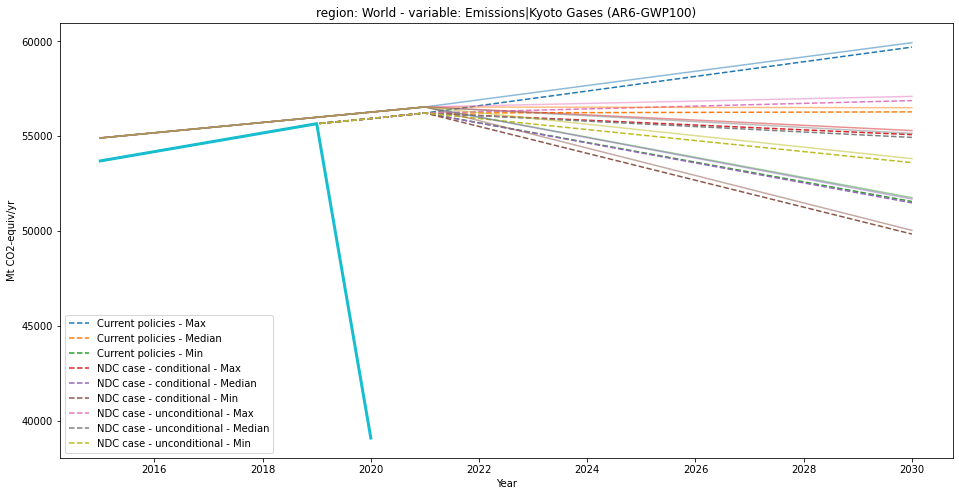

In [44]:
figure = plt.figure(figsize=(16, 8))
ax = plt.subplot(111)

harm_world.filter(variable=variable, region="World").plot(ax=ax, linestyle="--")
histall.filter(variable=variable, year=harm_world.year).plot(ax=ax, linestyle="-", linewidth=3)
raw_data.filter(variable=variable, region="World").plot(ax=ax, linestyle="-", alpha=0.5)

In [45]:
# Denote harmonisation in scenario names
harm_world = pyam.IamDataFrame(harm_world).data
harm_world["scenario"] = harm_world["scenario"] + "|Harmonized"
harm_world = pyam.IamDataFrame(harm_world)

In [46]:
# Since we don't have regional info in this case
harm_all = harm_world

In [47]:
# Harmonize sr15 too!
harmable_sr15_vars = [
    'Emissions|BC',
    'Emissions|CH4',
    'Emissions|CO',
    'Emissions|CO2',
    'Emissions|CO2|AFOLU',
    'Emissions|CO2|Energy and Industrial Processes',
    'Emissions|F-Gases',
    'Emissions|N2O',
    'Emissions|NH3',
    'Emissions|NOx',
    'Emissions|OC',
    'Emissions|Sulfur',
    'Emissions|VOC',
]

try:
    del harmed_sr15
except:
    pass
for harmvariable in harmable_sr15_vars:
    to_harm = sr15.filter(variable=harmvariable, region="World").interpolate(harmyear)
    harmed_sr15_cmpt = harmonize(
        to_harm, harmvariable, histall.filter(region="World"), harmyear)
    try:
        harmed_sr15 = harmed_sr15.append(harmed_sr15_cmpt)
    except: 
        harmed_sr15 = harmed_sr15_cmpt
# Some variables don't exist often enough in the chosen scenarios
fgas_harmvars = [
    'Emissions|SF6',
    'Emissions|HFC',
    'Emissions|PFC',
    'Emissions|PFC|C2F6',
    'Emissions|PFC|CF4'
]
for harmvariable in fgas_harmvars:
    to_harm = sr15.filter(variable=harmvariable, region="World").interpolate(harmyear)
    harmed_sr15_cmpt = harmonize(to_harm, harmvariable, histall.filter(region="World"), harmyear)
    harmed_sr15 = harmed_sr15.append(harmed_sr15_cmpt)
# And the gases that exist as subcomponents of HFCs are impossible to harmonise and simply appended. 
harmed_sr15 = harmed_sr15.append(sr15.filter(region="World", variable="*|HFC|*"))

unit mismatch for  ['Mt NOx/yr'] (desired) and ['Mt NO2/yr'] (current) for variable Emissions|NOx
Converted unit of Emissions|NOx to ['Mt NO2/yr']
unit mismatch for  ['Mt CO2-equiv/yr'] (desired) and ['kt HFC134a-equiv/yr'] (current) for variable Emissions|HFC
Converted unit of Emissions|HFC to ['Mt CO2-equiv/yr']
unit mismatch for  ['Mt CO2-equiv/yr'] (desired) and ['kt CF4-equiv/yr'] (current) for variable Emissions|PFC
Converted unit of Emissions|PFC to ['Mt CO2-equiv/yr']


In [49]:
# Introduce the Kyoto gas total with AR6
kyoto_gases = [
    'Emissions|CH4',
    'Emissions|CO2',
    'Emissions|F-Gases',
    'Emissions|N2O'
]
# We don't want scenarios that are lacking Fgases in the analysis
harmed_sr15.set_meta_from_data(name="HasFgas", region="World", variable=fgas, year=2020, method=np.nanmax)
harmed_sr15_hasfgas = harmed_sr15.filter(HasFgas=harmed_sr15.meta.HasFgas.unique())
sr15_ky_ar6 = _construct_consistent_values(
    variable, 
    kyoto_gases, 
    convert_units_to_MtCO2_equiv(harmed_sr15_hasfgas.filter(
        region="World", variable=kyoto_gases, model=models), metric_name="AR6GWP100")
)

In [50]:
kyoto_gases

['Emissions|CH4', 'Emissions|CO2', 'Emissions|F-Gases', 'Emissions|N2O']

In [51]:
assert len(sr15_ky_ar6.timeseries().loc[:, 2015].drop_duplicates().values) == 1

In [52]:
assert len(sr15_ky_ar6.timeseries().loc[:, 2019].drop_duplicates().values) == 1

In [53]:
assert np.allclose(
    histkyoto.filter(year=2015).data.value, 
    sr15_ky_ar6.filter(year=2015).data.value.unique()
)

In [54]:
assert np.allclose(
    histkyoto.filter(year=2019).data.value, 
    sr15_ky_ar6.filter(year=2019).data.value.unique()
)

In [55]:
assert not np.allclose(
    histkyoto.filter(year=2020).data.value, 
    sr15_ky_ar6.filter(year=2020).data.value.unique()
)

pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'region: World - variable: Emissions|Kyoto Gases (AR6-GWP100)'}, xlabel='Year', ylabel='Mt CO2-equiv/yr'>

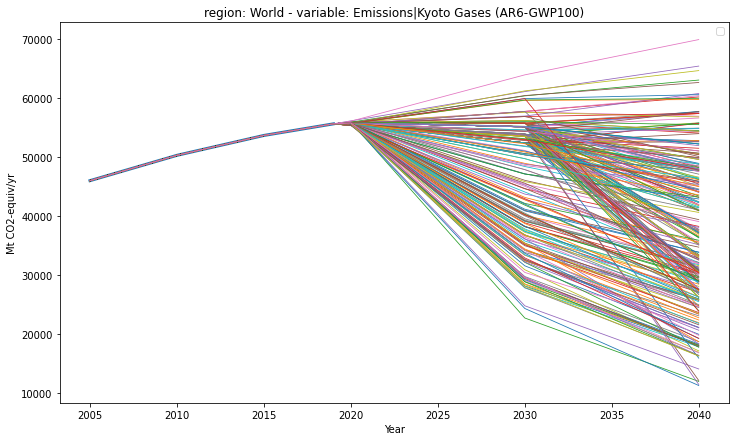

In [56]:
plt.figure(figsize=(12, 7))
ax = plt.subplot()
histkyoto.filter(year=[2005, 2010, 2015, 2019]).plot(ax=ax, linewidth=3)
sr15_ky_ar6.filter(year=[2005, 2010, 2015, 2019, 2020, 2030, 2040]).plot(ax=ax, linewidth=0.8)

In [57]:
harmed_sr15 = harmed_sr15.append(sr15_ky_ar6)

In [58]:
sr15.filter(variable="Emissions|CH4", scenario="2.5C", region="World", year=[2015, 2020, 2030, 2040, 2050]).timeseries()

,,,,,2015,2020,2030,2040,2050
model,scenario,region,variable,unit,,,,,
AIM/Hub-Global 2.0,2.5C,World,Emissions|CH4,Mt CH4/yr,391.6731,412.605,374.0819,400.4428,325.6247


In [59]:
harmed_sr15.filter(variable="Emissions|CH4", scenario="2.5C", region="World", year=[2015, 2020, 2030, 2040, 2050]).timeseries().values / sr15.filter(variable="Emissions|CH4", scenario="2.5C", region="World", year=[2015, 2020, 2030, 2040, 2050]).timeseries()

,,,,,2015,2020,2030,2040,2050
model,scenario,region,variable,unit,,,,,
AIM/Hub-Global 2.0,2.5C,World,Emissions|CH4,Mt CH4/yr,0.933716,0.9285,0.95267,0.975762,1.0


pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


(2005.0, 2060.0)

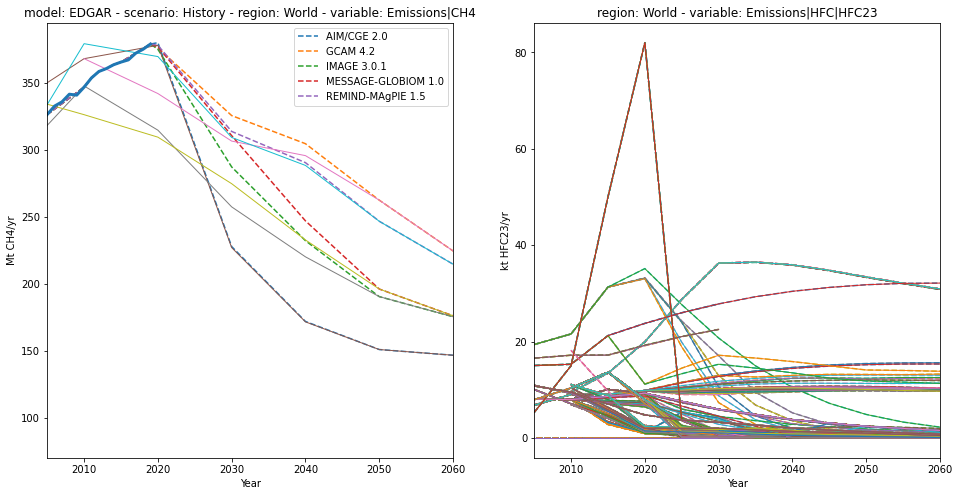

In [60]:
figure = plt.figure(figsize=(16, 8))
ax = plt.subplot(121)
harmed_sr15.filter(variable="Emissions|CH4", scenario="SSP1-2*", region="World").plot(ax=ax, linestyle="--")
sr15.filter(variable="Emissions|CH4", scenario="SSP1-2*", region="World").plot(ax=ax, linewidth=1)
histall.filter(variable="Emissions|CH4", region="World").plot(ax=ax, linewidth=3)
plt.xlim([2005, 2060])
ax = plt.subplot(122)
harmed_sr15.filter(variable="Emissions|HFC|HFC23", region="World").plot(ax=ax, linestyle="--")
sr15.filter(variable="Emissions|HFC|HFC23", region="World").plot(ax=ax, linewidth=1)
plt.xlim([2005, 2060])

In [61]:
# harmonise the regional variables in  where historic regional variables exist, 
# unify them where they don't
regional_var = [var for var in harmable_sr15_vars 
                if (var in histall.filter(region="R10CHINA+").variable) & (
                var in sr15.filter(region="R10CHINA+", model=models).variable)]
non_region_var = [var for var in harmable_sr15_vars if var not in regional_var]
regional_var

['Emissions|CH4',
 'Emissions|CO2|Energy and Industrial Processes',
 'Emissions|F-Gases',
 'Emissions|N2O']

In [62]:
orig_ssps = sr15.filter(model=models).interpolate(harmyear)
regional_ssps = orig_ssps.filter(region="World", keep=False).append(harmed_sr15)

In [63]:
if harmonise_regions_to_whole:
    harmed_sr15_regions_to_tot = harmonise_regions_to_total(
        orig_ssps.timeseries().reset_index(), harmed_sr15, years, non_region_var
    )
    harmed_sr15_regions_to_tot = pyam.concat(harmed_sr15_regions_to_tot)
else:
    harmed_sr15_regions_to_tot = orig_ssps.filter(variable=non_region_var)

In [64]:
harmed_sr15_regions_to_tot.check_aggregate_region(co2afolu)

pyam.core - INFO: `Emissions|CO2|AFOLU` - 328 of 4838 rows are not aggregates of subregions


region  \
model                 scenario                   region variable            unit      year                
MESSAGEix-GLOBIOM_1.1 EN_INDCi2030_1000          World  Emissions|CO2|AFOLU Mt CO2/yr 2000  5811.870900   
                                                                                      2005  5837.544167   
                      EN_INDCi2030_1000_COV      World  Emissions|CO2|AFOLU Mt CO2/yr 2000  5811.870900   
                                                                                      2005  5837.544167   
                      EN_INDCi2030_1000_COV_NDCp World  Emissions|CO2|AFOLU Mt CO2/yr 2000  5811.870900   
...                                                                                                 ...   
                      EN_NPi2100                 World  Emissions|CO2|AFOLU Mt CO2/yr 2005  5837.544167   
                      EN_NPi2100_COV             World  Emissions|CO2|AFOLU Mt CO2/yr 2000  5811.870900   
                                                                                      2005  5837.544167   
                      EN_NoPolicy                World  Emissions|CO2|AFOLU Mt CO2/yr 2000  5811.870900   
                                                                                      2005  5837.544167   

                                                                                            subregions  
model                 scenario                   region variable            unit      year              
MESSAGEix-GLOBIOM_1.1 EN_INDCi2030_1000          World  Emissions|CO2|AFOLU Mt CO2/yr 2000         NaN  
                                                                                      2005         NaN  
                      EN_INDCi2030_1000_COV      World  Emissions|CO2|AFOLU Mt CO2/yr 2000         NaN  
                                                                                      2005         NaN  
                      EN_INDCi2030_1000_COV_NDCp World  Emissions|CO2|AFOLU Mt CO2/yr 2000         NaN  
...                                                                                                ...  
                      EN_NPi2100                 World  Emissions|CO2|AFOLU Mt CO2/yr 2005         NaN  
                      EN_NPi2100_COV             World  Emissions|CO2|AFOLU Mt CO2/yr 2000         NaN  
                                                                                      2005         NaN  
                      EN_NoPolicy                World  Emissions|CO2|AFOLU Mt CO2/yr 2000         NaN  
                                                                                      2005         NaN  

[328 rows x 2 columns]

In [65]:
orig_ssps.check_aggregate_region(co2afolu)

pyam.core - INFO: `Emissions|CO2|AFOLU` - 328 of 4838 rows are not aggregates of subregions


region  \
model                 scenario                   region variable            unit      year                
MESSAGEix-GLOBIOM_1.1 EN_INDCi2030_1000          World  Emissions|CO2|AFOLU Mt CO2/yr 2000  5811.870900   
                                                                                      2005  5837.544167   
                      EN_INDCi2030_1000_COV      World  Emissions|CO2|AFOLU Mt CO2/yr 2000  5811.870900   
                                                                                      2005  5837.544167   
                      EN_INDCi2030_1000_COV_NDCp World  Emissions|CO2|AFOLU Mt CO2/yr 2000  5811.870900   
...                                                                                                 ...   
                      EN_NPi2100                 World  Emissions|CO2|AFOLU Mt CO2/yr 2005  5837.544167   
                      EN_NPi2100_COV             World  Emissions|CO2|AFOLU Mt CO2/yr 2000  5811.870900   
                                                                                      2005  5837.544167   
                      EN_NoPolicy                World  Emissions|CO2|AFOLU Mt CO2/yr 2000  5811.870900   
                                                                                      2005  5837.544167   

                                                                                            subregions  
model                 scenario                   region variable            unit      year              
MESSAGEix-GLOBIOM_1.1 EN_INDCi2030_1000          World  Emissions|CO2|AFOLU Mt CO2/yr 2000         NaN  
                                                                                      2005         NaN  
                      EN_INDCi2030_1000_COV      World  Emissions|CO2|AFOLU Mt CO2/yr 2000         NaN  
                                                                                      2005         NaN  
                      EN_INDCi2030_1000_COV_NDCp World  Emissions|CO2|AFOLU Mt CO2/yr 2000         NaN  
...                                                                                                ...  
                      EN_NPi2100                 World  Emissions|CO2|AFOLU Mt CO2/yr 2005         NaN  
                      EN_NPi2100_COV             World  Emissions|CO2|AFOLU Mt CO2/yr 2000         NaN  
                                                                                      2005         NaN  
                      EN_NoPolicy                World  Emissions|CO2|AFOLU Mt CO2/yr 2000         NaN  
                                                                                      2005         NaN  

[328 rows x 2 columns]

In [66]:
harmed_sr15_regions = harmed_sr15_regions_to_tot

prop_harmed_sr15_regions = []
regions = [r for r in harmed_sr15_regions_to_tot.region if r != "World"]
for var in regional_var:
    for region in regions:
        if not histall.filter(variable=var, region=region).empty:
            prop_harmed_sr15_regions.append(
                harmonize(
                    regional_ssps.filter(variable=var, region=region), 
                    var, 
                    histall.filter(variable=var, region=region),
                    harmyear
                )
            )
harmed_sr15_regions = pyam.concat(prop_harmed_sr15_regions + [harmed_sr15_regions]).filter(year=2005, keep=False)

pyam.core - WARNING: Filtered IamDataFrame is empty!


In [67]:
orig_ssps.filter(variable=var, model="REMIND-MAgPIE 2.1*", scenario="EN*").region

['R10AFRICA',
 'R10CHINA+',
 'R10EUROPE',
 'R10INDIA+',
 'R10LATIN_AM',
 'R10MIDDLE_EAST',
 'R10NORTH_AM',
 'R10PAC_OECD',
 'R10REF_ECON',
 'R10REST_ASIA',
 'R10ROWO',
 'World']

pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


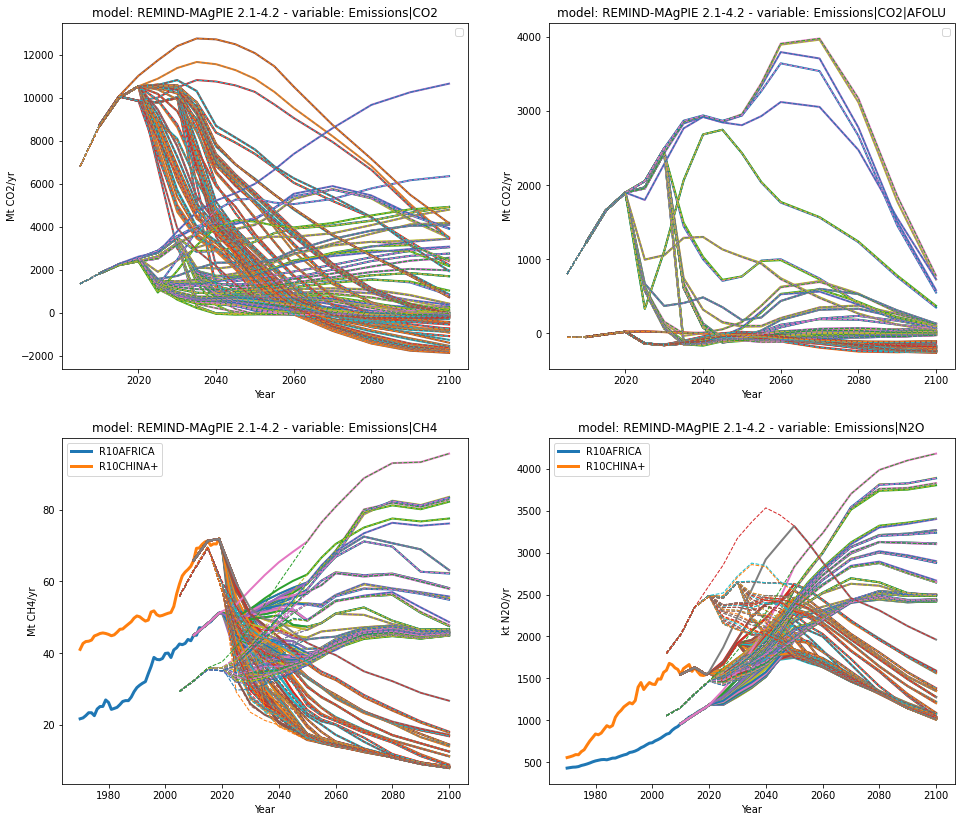

In [68]:
ch4 = "Emissions|CH4"
to_plot = [co2, co2afolu, ch4, "Emissions|N2O"]
plt.figure(figsize=(16, 14))
for i in range(4):
    var = to_plot[i]
    ax=plt.subplot(2, 2, i+1)
    histall.filter(variable=var, region=["R10AFRICA", "R10CHINA+"]).plot(ax=ax, linestyle="-", linewidth=3)
    harmed_sr15_regions.filter(variable=var, model="REMIND-MAgPIE 2.1*", scenario="EN*", region=["R10AFRICA", "R10CHINA+"]).plot(ax=ax, linewidth=2)
    orig_ssps.filter(variable=var, model="REMIND-MAgPIE 2.1*", scenario="EN*", region=["R10AFRICA", "R10CHINA+"]).plot(ax=ax, linestyle="--", linewidth=1)

In [69]:
# We don't expect there to be deviations between the global and regional emissions for these harmonised variables
assert harmed_sr15_regions.check_aggregate_region(var) == None

pyam.core - INFO: Variable 'Emissions|N2O' does not exist in region 'World'!


In [70]:
sr15_region_ky_ar6 = _construct_consistent_values(
    variable, 
    kyoto_gases, 
    convert_units_to_MtCO2_equiv(harmed_sr15_regions.filter(
        variable=kyoto_gases,), metric_name="AR6GWP100")
)

In [71]:
sr15_region_ky_ar6

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : MESSAGEix-GLOBIOM_1.1, REMIND-MAgPIE 2.1-4.2 (2)
 * scenario : CEMICS_SSP1-1p5C-fullCDR, CEMICS_SSP1-1p5C-minCDR, ... SusDev_SSP2-PkBudg900 (203)
Timeseries data coordinates:
   region   : R10AFRICA, R10CHINA+, R10EUROPE, R10INDIA+, ... World (12)
   variable : Emissions|Kyoto Gases (AR6-GWP100) (1)
   unit     : Mt CO2-equiv/yr (1)
   year     : 2000, 2010, 2015, 2019, 2020, 2025, 2030, 2035, ... 2100 (17)
Meta indicators:
   exclude (bool) False (1)

In [74]:
check = sr15_region_ky_ar6.filter(region="R10CHINA+").timeseries()[2015].values
assert (max(check) - min (check)) / np.mean(check) < 0.07

In [75]:
harmed_sr15_regions = harmed_sr15_regions.append(sr15_region_ky_ar6)

pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'model: MESSAGEix-GLOBIOM_1.1 - region: R10EUROPE - variable: Emissions|Kyoto Gases (AR6-GWP100)'}, xlabel='Year', ylabel='Mt CO2-equiv/yr'>

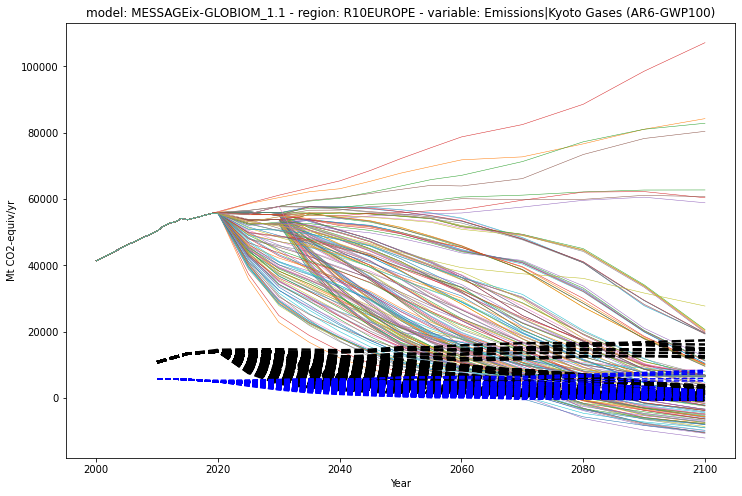

In [78]:
plt.figure(figsize=(12, 8))
model="MESSAGE*"
ax=plt.subplot()
harmed_sr15.filter(model=model, variable=variable, region="World").plot(ax=ax, linewidth=0.5)
harmed_sr15_regions.filter(model=model, variable=variable, region="R10CHINA+").plot(
    ax=ax, linestyle="--", color="black", linewidth=2.5)
harmed_sr15_regions.filter(model=model, variable=variable, region="R10EUROPE").plot(
    ax=ax, linestyle="--", color="blue", linewidth=1.5)

pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'model: MESSAGEix-GLOBIOM_1.1 - region: R10EUROPE - variable: Emissions|CO2|AFOLU'}, xlabel='Year', ylabel='Mt CO2/yr'>

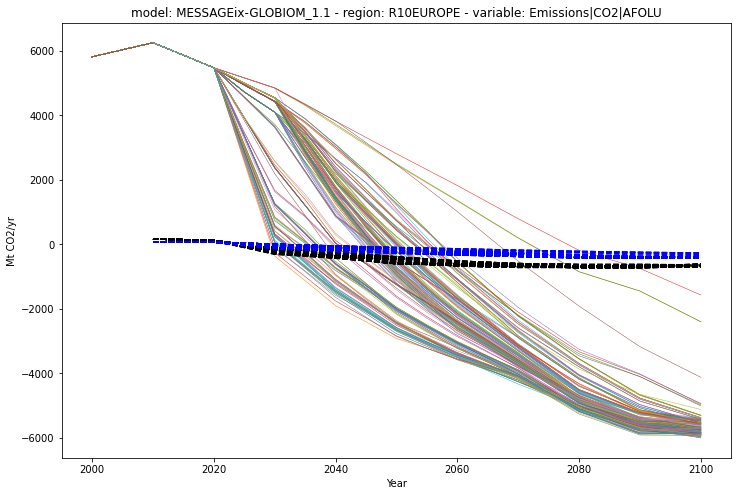

In [79]:
plt.figure(figsize=(12, 8))
model="MESSAGE*"
ax=plt.subplot()
harmed_sr15_regions.filter(model=model, variable=co2afolu, region="World").plot(ax=ax, linewidth=0.5)
harmed_sr15_regions.filter(model=model, variable=co2afolu, region="R10CHINA+").plot(
    ax=ax, linestyle="--", color="black", linewidth=1.5)
harmed_sr15_regions.filter(model=model, variable=co2afolu, region="R10EUROPE").plot(
    ax=ax, linestyle="--", color="blue", linewidth=1.5)

pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'region: World - variable: Emissions|SF6'}, xlabel='Year', ylabel='kt SF6/yr'>

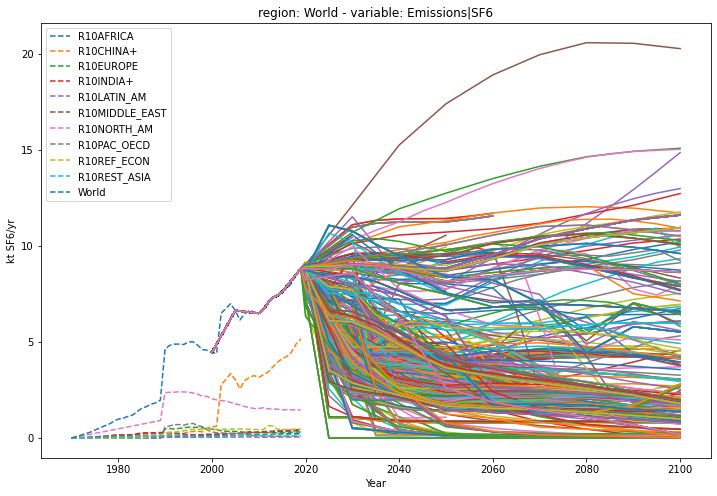

In [80]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111)
histall.filter(variable="*SF6").plot(ax=ax, linestyle="--")
harmed_sr15.filter(variable="*SF6", region="World").plot(ax=ax)

In [81]:
harmed_sr15_regions.filter(model=model, variable=co2afolu).check_aggregate_region(co2afolu)

pyam.core - INFO: `Emissions|CO2|AFOLU` - 164 of 2884 rows are not aggregates of subregions


region  \
model                 scenario                   region variable            unit      year              
MESSAGEix-GLOBIOM_1.1 EN_INDCi2030_1000          World  Emissions|CO2|AFOLU Mt CO2/yr 2000  5811.8709   
                      EN_INDCi2030_1000_COV      World  Emissions|CO2|AFOLU Mt CO2/yr 2000  5811.8709   
                      EN_INDCi2030_1000_COV_NDCp World  Emissions|CO2|AFOLU Mt CO2/yr 2000  5811.8709   
                      EN_INDCi2030_1000_NDCp     World  Emissions|CO2|AFOLU Mt CO2/yr 2000  5811.8709   
                      EN_INDCi2030_1000f         World  Emissions|CO2|AFOLU Mt CO2/yr 2000  5811.8709   
...                                                                                               ...   
                      EN_NPi2020_900f            World  Emissions|CO2|AFOLU Mt CO2/yr 2000  5811.8709   
                      EN_NPi2020_900f_COV        World  Emissions|CO2|AFOLU Mt CO2/yr 2000  5811.8709   
                      EN_NPi2100                 World  Emissions|CO2|AFOLU Mt CO2/yr 2000  5811.8709   
                      EN_NPi2100_COV             World  Emissions|CO2|AFOLU Mt CO2/yr 2000  5811.8709   
                      EN_NoPolicy                World  Emissions|CO2|AFOLU Mt CO2/yr 2000  5811.8709   

                                                                                            subregions  
model                 scenario                   region variable            unit      year              
MESSAGEix-GLOBIOM_1.1 EN_INDCi2030_1000          World  Emissions|CO2|AFOLU Mt CO2/yr 2000         NaN  
                      EN_INDCi2030_1000_COV      World  Emissions|CO2|AFOLU Mt CO2/yr 2000         NaN  
                      EN_INDCi2030_1000_COV_NDCp World  Emissions|CO2|AFOLU Mt CO2/yr 2000         NaN  
                      EN_INDCi2030_1000_NDCp     World  Emissions|CO2|AFOLU Mt CO2/yr 2000         NaN  
                      EN_INDCi2030_1000f         World  Emissions|CO2|AFOLU Mt CO2/yr 2000         NaN  
...                                                                                                ...  
                      EN_NPi2020_900f            World  Emissions|CO2|AFOLU Mt CO2/yr 2000         NaN  
                      EN_NPi2020_900f_COV        World  Emissions|CO2|AFOLU Mt CO2/yr 2000         NaN  
                      EN_NPi2100                 World  Emissions|CO2|AFOLU Mt CO2/yr 2000         NaN  
                      EN_NPi2100_COV             World  Emissions|CO2|AFOLU Mt CO2/yr 2000         NaN  
                      EN_NoPolicy                World  Emissions|CO2|AFOLU Mt CO2/yr 2000         NaN  

[164 rows x 2 columns]

In [82]:
sr15.filter(model=model, variable=co2afolu).check_aggregate_region(co2afolu)

pyam.core - INFO: `Emissions|CO2|AFOLU` - 1018 of 4207 rows are not aggregates of subregions


region  \
model                 scenario               region variable            unit      year                
MESSAGE-GLOBIOM 1.0   ADVANCE_2020_1.5C-2100 World  Emissions|CO2|AFOLU Mt CO2/yr 2005  6762.782717   
                                                                                  2010  6933.193447   
                                                                                  2020  5032.082656   
                                                                                  2030  1053.420698   
                                                                                  2040  -642.367183   
...                                                                                             ...   
MESSAGEix-GLOBIOM_1.2 COV_SmartUse           World  Emissions|CO2|AFOLU Mt CO2/yr 1995          NaN   
                      COV_SmartUse_1000      World  Emissions|CO2|AFOLU Mt CO2/yr 1990          NaN   
                                                                                  1995          NaN   
                      COV_SmartUse_550       World  Emissions|CO2|AFOLU Mt CO2/yr 1990          NaN   
                                                                                  1995          NaN   

                                                                                        subregions  
model                 scenario               region variable            unit      year              
MESSAGE-GLOBIOM 1.0   ADVANCE_2020_1.5C-2100 World  Emissions|CO2|AFOLU Mt CO2/yr 2005         NaN  
                                                                                  2010         NaN  
                                                                                  2020         NaN  
                                                                                  2030         NaN  
                                                                                  2040         NaN  
...                                                                                            ...  
MESSAGEix-GLOBIOM_1.2 COV_SmartUse           World  Emissions|CO2|AFOLU Mt CO2/yr 1995   5811.8709  
                      COV_SmartUse_1000      World  Emissions|CO2|AFOLU Mt CO2/yr 1990   5811.8709  
                                                                                  1995   5811.8709  
                      COV_SmartUse_550       World  Emissions|CO2|AFOLU Mt CO2/yr 1990   5811.8709  
                                                                                  1995   5811.8709  

[1018 rows x 2 columns]

<AxesSubplot:title={'center':'scenario: EMF30_D_CO2-Only - region: World - variable: Emissions|CO2'}, xlabel='Year', ylabel='Mt CO2/yr'>

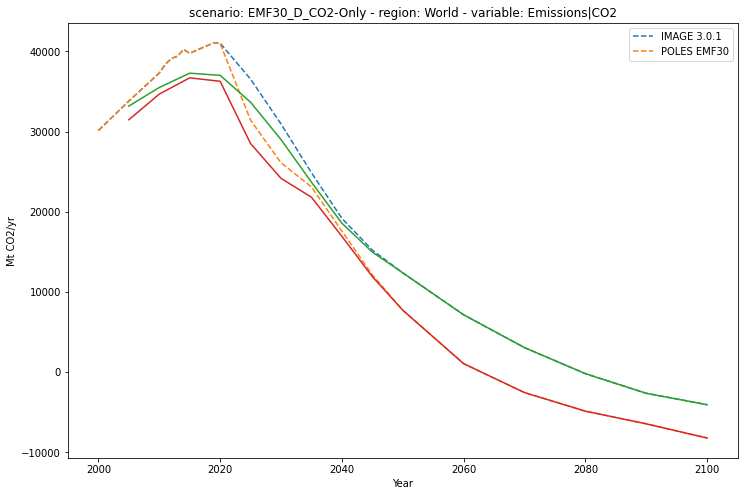

In [83]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111)
harmed_sr15.filter(variable=co2, scenario=harmed_sr15.scenario[132:133]).plot(ax=ax, linestyle="--")
sr15.filter(variable=co2, scenario=harmed_sr15.scenario[132:133]).plot(ax=ax)

# Plot distribution of 2030 values

In [84]:
harm_all_but_old_names = harm_all.filter(variable=variable, region="World", year=2030).data
harm_all_but_old_names["scenario"] = harm_all_but_old_names["scenario"].str.replace(
    "\|Harmonized", "")
compare_harms_ky = pd.merge(
    raw_data.filter(variable=variable, region="World", year=2030).data,
    harm_all_but_old_names,
    on=("model", "scenario", "region", "year", "variable", "unit"),
    how="outer"
)
compare_harms_ky = compare_harms_ky.rename(columns={"value_x": "Unharmonized", "value_y": "Harmonized"})

C:\Users\rlamboll\Anaconda3\envs\silicone-1\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 20.799999999999983, 'Unharmonized 2030 Kyoto total (Mt CO2)')

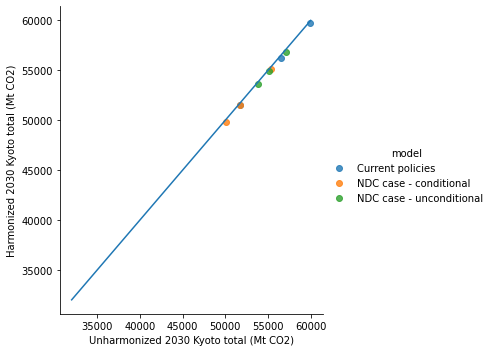

In [86]:
sns.lmplot(x='Unharmonized', y='Harmonized', data=compare_harms_ky, hue='model', fit_reg=False)
plt.plot([32000, 60000], [32000, 60000])
plt.ylabel("Harmonized 2030 Kyoto total (Mt CO2)")
plt.xlabel("Unharmonized 2030 Kyoto total (Mt CO2)")

In [87]:
compare_harms_ky = compare_harms_ky.melt(
    [c for c in compare_harms_ky.columns if c not in ["Unharmonized", "Harmonized"]], var_name="Harmonization"
)
compare_harms_ky.head()

,model,scenario,region,variable,unit,year,Harmonization,value
0,Current policies,Max,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2030,Unharmonized,59927.353077
1,Current policies,Median,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2030,Unharmonized,56499.478534
2,Current policies,Min,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2030,Unharmonized,51754.515639
3,NDC case - conditional,Max,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2030,Unharmonized,55293.627546
4,NDC case - conditional,Median,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2030,Unharmonized,51683.988603


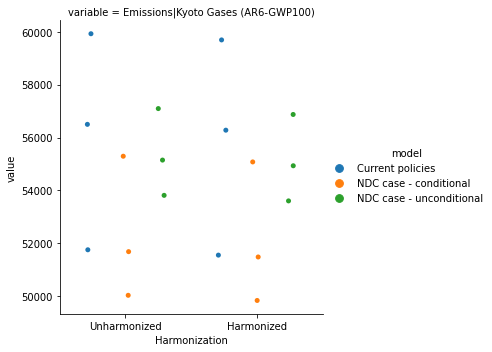

In [88]:
sns.catplot(x="Harmonization", y="value", col="variable", hue="model", 
            data=compare_harms_ky, dodge=True)

# Output harmonised values

In [89]:
if not os.path.exists(out_folder):
    os.mkdir(out_folder)
harm_all.to_csv(out_folder + f"harm_all_{version_no}.csv")
harmed_sr15.to_csv(out_folder + "ar6_cleaned_harmed.csv")
harmed_sr15_regions.to_csv(out_folder + "ar6_cleaned_harmed_regions.csv")